In [1]:
# !pip install pgmpy daft #pyAgrum 

In [21]:
import sys
from os import path
sys.path.append(path.join("..", "src"))
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, ConcatDataset, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from packages.spn.experiments.RandomSPNs_layerwise.rat_spn import RatSpn, RatSpnConfig
from packages.spn.experiments.RandomSPNs_layerwise.distributions import RatNormal
from packages.spn.algorithms.layerwise.distributions import Bernoulli, Categorical
from constraint.constraints import *
import time
import argparse
from tqdm import tqdm
from pathlib import Path

<Axes: >

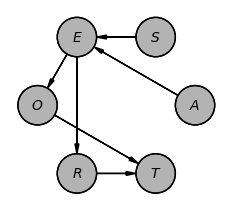

In [22]:
from pgmpy.readwrite import BIFReader
name = "survey"
bn = BIFReader(f"{name}.bif").get_model()
bn.to_daft().render()

In [23]:
from pgmpy.models import BayesianNetwork
import pandas as pd
from pgmpy.inference import VariableElimination
from itertools import product
import numpy as np
def compute_monotonic_influences_from_bn(model: BayesianNetwork, frame: pd.DataFrame, r: list, sign: int, epsilon: float):
  rows = []
  names = frame.columns.tolist()
  inference = VariableElimination(model)
  for first, second in product(frame.columns, frame.columns):
    if first == second: continue
    numerator = inference.query([first, second], show_progress=False)
    denominator = inference.query([second], show_progress=False)
    frange = list(range(r[names.index(first)]))
    srange = list(range(r[names.index(second)]))
    terms = np.array([
      np.cumsum([numerator.get_value(**{first: fval, second: sval}) / denominator.get_value(**{second: sval})
                 for fval in frange[:-1]])
      for sval in srange
    ]).T
    #  first is influenced by second

    diffs = np.fromiter((
      sign * (row[vj2] - row[vj1])
      for row in terms
      for vj2, vj1 in product(srange, srange)
      if vj2 > vj1
    ), dtype=float)

    C = np.all((diffs + epsilon) < 0)
    degree = C * np.sum(diffs) / len(srange)
    rows.append((first, second, degree))

  return pd.DataFrame(rows, columns=("First", "Second", "Degree"))
#e - >r
train = bn.simulate(n_samples=100)
bn.fit(train)
r = [bn.get_cardinality(each) for each in train.columns]
f = compute_monotonic_influences_from_bn(bn ,train, r, +1, 0.01)
f[f.Degree != 0]

  0%|          | 0/6 [00:00<?, ?it/s]

,First,Second,Degree
6,O,E,-0.006667
11,E,O,-0.041717
12,E,R,-0.037562
17,R,E,-0.040000


In [24]:
r

[2, 2, 2, 2, 3, 3]

In [25]:
def get_cis(bn):
    return [
        (list(indep.event1)[0], each, list(indep.event3)[0])
        
        for indep in bn.get_independencies().get_assertions()
        for each in indep.event2
        if len(indep.event3)==1
    ]

import random
cis = get_cis(bn)

In [26]:
train = bn.simulate(n_samples=100, seed=0).astype(int) # sample_from_bn("sachs", 100)
# train.replace({"LOW": 0, "AVG": 1, "HIGH": 2}, inplace=True)

test = bn.simulate(n_samples=100, seed=1).astype(int) # sample_from_bn("sachs", 100)
# test.replace({"LOW": 0, "AVG": 1, "HIGH": 2}, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
train.to_csv("survey-train.csv", index=False)
test.to_csv("survey-test.csv", index=False)

In [28]:
use_cuda=False
kwargs = {"num_workers": 8, "pin_memory": True} if use_cuda else {}
batch_size = 64
test_batch_size = batch_size


train_dataset, test_dataset = TensorDataset(torch.Tensor(train.to_numpy())), TensorDataset(torch.Tensor(test.to_numpy()))
# Train data loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    **kwargs,
)

# Test data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    **kwargs,
)
names = train.columns.tolist()

In [29]:
def make_spn(S, I, R, D, F, C, device, leaf_base_class, leaf_base_kwargs=None) -> RatSpn:
        """Construct the RatSpn"""

        # Setup RatSpnConfig
        config = RatSpnConfig()
        config.F = F
        config.R = R
        config.D = D
        config.I = I
        config.S = S
        config.C = C
        config.dropout = 0.0
        config.leaf_base_class = leaf_base_class 
        config.leaf_base_kwargs = {} if leaf_base_kwargs is None else leaf_base_kwargs

        # Construct RatSpn from config
        model = RatSpn(config)

        model = model.to(device)
        model.train()

        print("Using device:", device)
        return model


rat_S, rat_I, rat_D, rat_R, rat_C, leaves =  20, 20, 2, 5, 1,Categorical 
n_features = train_loader.dataset[0][0].shape[0]
r = [bn.get_cardinality(each) for each in test.columns]
device = torch.device("cpu") # torch.device("cuda")
dropout = 0
model = make_spn(S=rat_S, I=rat_I, D=rat_D, R=rat_R, device=device, F=n_features, C=rat_C,leaf_base_class=leaves, leaf_base_kwargs=dict(num_bins=max(r)))

Using device: cpu


In [30]:
from tqdm import trange
def train_model(model, train_loader, constraints, n_iterations=1000, t_max=0, tol=1e-4, device='cpu'):
    
    
    prev_loss, total_loss = 0, 0
    rel_change_loss, rel_change_penalty = 0, 0
    prev_penalty, total_penalty = 0, 0
    config_data = {}
    prev_loss = 0
    patience = 0
    lambda_ = 0

    for t in range(-1, t_max):
        model.train()
        optimizer = optim.Adam(model.parameters(), lr = 1e-3 if t == -1 else 1e-4)
        # torch.cuda.empty_cache()
        total_data_loss, total_penalty = 0, 0
        patience = 0
        prev_loss = 0
        for iteration in trange(n_iterations*10 if t == -1 else n_iterations):
            total_loss = 0
            for (data,) in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = -outputs.sum() / data.shape[0]
                total_data_loss += loss.detach()
                
                penalty = torch.tensor(0.0, device=device)
                for constraint in constraints:
                    penalty += constraint.violation(model, train_loader.dataset, config_data, device=device, batch_size=64)

                
                total_penalty += penalty.detach()
                # print (loss, penalty, lambda_)
                if t >= 0:
                    lambda_ = 10**t
                    loss += lambda_*penalty
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
            
            
            if iteration > 0:
                rel_change_loss = (prev_loss - total_loss) / prev_loss
                
                if patience >= 2 and rel_change_loss < tol:
                    break
                else:
                    patience += 1
                
                if rel_change_loss > tol:
                    patience = 0
            prev_loss = total_loss
        
        with torch.no_grad():
            penalty = torch.tensor(0.0, device=device)
            for constraint in constraints:
                penalty += constraint.violation(model, train_loader.dataset, config_data, device=device, batch_size=64)
        total_penalty = float(penalty)
        
        print (f"{iteration} {t} {total_data_loss/(iteration+1):.4f} {rel_change_loss} {total_penalty}")
        if total_penalty < tol:
            break
        
    return model

In [31]:

def train_model(model, train_loader, constraints, n_iterations=1000, t_min=-1, t_max=0, tol=1e-4, device='cpu'):
    
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    prev_loss, total_loss = 0, 0
    rel_change_loss, rel_change_penalty = 0, 0
    prev_penalty, total_penalty = 0, 0
    config_data = {}
    prev_loss = 0
    for t in range(t_min, t_max):
        # torch.cuda.empty_cache()
        total_data_loss, total_penalty = 0, 0
        for iteration in trange(n_iterations):
            total_loss = 0
            for (data,) in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = -outputs.sum() / data.shape[0]
                total_data_loss += loss.detach()
                
                penalty = torch.tensor(0.0, device=device)
                for constraint in constraints:
                    penalty += constraint.violation(model, train_loader.dataset, config_data, device=device, batch_size=64)
                
                total_penalty += penalty.detach()
                if t >= 0:
                    lambda_ = 10**t
                    loss += lambda_*penalty
                total_loss += loss.detach()
                loss.backward()
                optimizer.step()
            
            
            if iteration > 0:
                rel_change_loss = (prev_loss - total_loss) / prev_loss
                
            """
            if iteration >0 and rel_change_loss < tol:
                break
            """
            prev_loss = total_loss

        with torch.no_grad():
            penalty = torch.tensor(0.0, device=device)
            for constraint in constraints:
                penalty += constraint.violation(model, train_loader.dataset, config_data, device=device, batch_size=64)
        total_penalty = float(penalty)
        
        
        print (f"{iteration} {t} {total_data_loss/(iteration+1):.4f} {rel_change_loss} {total_penalty/(iteration+1)}")
        if t >= 0 and total_penalty/(iteration+1) < tol:
            break
    return model

In [32]:
import numpy as np
trial = 0
random.seed(trial)
np.random.seed(trial)
torch.manual_seed(trial)

constraints = []

model = make_spn(S=rat_S, I=rat_I, D=rat_D, R=rat_R, device=device, F=n_features, C=rat_C,leaf_base_class=leaves, leaf_base_kwargs=dict(num_bins=max(r)))
model = train_model(model, train_loader, constraints, t_max=0, tol=1e-4, device=device, n_iterations=100)

Using device: cpu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]

99 -1 12.4597 0.0011115425731986761 0.0


In [33]:
log_likelihood(test_loader, model, device)

-583.8337860107422

In [34]:
import copy

trial = 1
random.seed(trial)
np.random.seed(trial)
torch.manual_seed(trial)


constraints = [
    ContextSpecificIndependence(names.index(X), names.index(Y), names.index(Z), z, r)
    for X, Y, Z in cis[0:1]
    for z in range(r[names.index(Z)])
] 


# model = make_spn(S=rat_S, I=rat_I, D=rat_D, R=rat_R, device=device, F=n_features, C=rat_C,leaf_base_class=leaves, leaf_base_kwargs=dict(num_bins=max(r)))
model2 = train_model(copy.deepcopy(model), train_loader, constraints, t_min=0, t_max=10, tol=1e-8, device=device, n_iterations=100)

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 92/100 [07:45<00:40,  5.05s/it]


KeyboardInterrupt: 

In [174]:
log_likelihood(test_loader, model2, device)

-315.603271484375

In [176]:

"""
parent1 = "either"
target1 = "xray"


parent1 = "Alarm"
target1 = "JohnCalls"
"""
parent1 = "E" # education
target1 = "R" # Residence
sign = +1
epsilon = 0.01
constraints = [
    ContextSpecificIndependence(names.index(X), names.index(Y), names.index(Z), z, r)
    for X, Y, Z in cis[0:1]
    for z in range(r[names.index(Z)])
] + [MonotonicityConstraint(names.index(parent1), names.index(target1), r, sign, epsilon)] 

model3 = train_model(copy.deepcopy(model2), train_loader, constraints, t_min=0, t_max=10, tol=1e-8, device=device, n_iterations=100)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


99 0 6.0701 -0.024036070331931114 6.057462305761874e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


99 1 5.7204 0.018915599212050438 5.962581417406909e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


99 2 5.5449 0.02896290086209774 5.662822150043212e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


99 3 5.4876 -0.040111031383275986 1.2110580428270622e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.70it/s]


99 4 5.4734 0.00404758658260107 5.939365291851573e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


99 5 5.4680 0.06987354904413223 7.627633749507367e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


99 6 5.4840 0.18960505723953247 8.934093057177961e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


99 7 5.4940 -0.07043761014938354 7.164580165408552e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


99 8 5.5063 0.0001959960354724899 5.463113120640628e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]

99 9 5.5330 0.00040852450183592737 5.323541336110794e-07


In [177]:
log_likelihood(test_loader, model3, device)

-280.2041473388672

In [151]:
!pip install deepcopy

ERROR: Could not find a version that satisfies the requirement deepcopy (from versions: none)
ERROR: No matching distribution found for deepcopy


In [101]:
trial = 0
random.seed(trial)
np.random.seed(trial)
torch.manual_seed(trial)

parent1 = "smoke"
target1 = "lung"

# parent2 = "tub"
# target2 = "either"
"""
16 	xray 	lung 	-0.441936
17 	xray 	either 	-0.465000
18 	xray 	tub 	-0.439425
31 	either 	lung 	-0.475200
32 	either 	tub 	-0.472500
"""


sign = +1
epsilon = 0.01
constraints =  [MonotonicityConstraint(names.index(parent1), names.index(target1), r, sign, epsilon)] #\
# + [MonotonicityConstraint(names.index(parent2), names.index(target2), r, sign, epsilon)] #\
# + [MonotonicityConstraint(names.index(parent3), names.index(target3), r, sign, epsilon)] #\


model = make_spn(S=rat_S, I=rat_I, D=rat_D, R=rat_R, device=device, F=n_features, C=rat_C,leaf_base_class=leaves, leaf_base_kwargs=dict(num_bins=max(r)))
model = train_model(model, train_loader, constraints, t_max=10, tol=1e-16, device=device, n_iterations=100)
constraints += [
    ContextSpecificIndependence(names.index(X), names.index(Y), names.index(Z), z, r)
    for X, Y, Z in cis[0:1]
    for z in range(r[names.index(Z)])
]
model = train_model(model, train_loader, constraints, t_max=10, tol=1e-16, device=device, n_iterations=100)

Using device: cpu


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.81it/s]


99 -1 5.4801 0.0008460879325866699 1.9239552784711124e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.06it/s]


99 0 5.0346 0.0008151134825311601 2.0924725686199962e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.52it/s]


99 1 4.6403 0.0007980785449035466 1.0437678429298102e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.38it/s]


99 2 4.2859 0.0007834988064132631 5.08313205500599e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.94it/s]


99 3 3.9633 0.0007541882805526257 5.001221143174916e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.03it/s]


99 4 3.6727 0.0006266795680858195 5.0000126066152e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.53it/s]


99 5 3.4211 0.000245171831920743 4.999999873689376e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.55it/s]


99 6 3.2138 7.898010153439827e-06 4.999999873689376e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.70it/s]


99 7 3.0518 2.6696213808463654e-06 4.999999873689376e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.96it/s]


99 8 2.9330 1.9519946192758653e-07 4.999999873689376e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.83it/s]


99 9 2.8597 0.0 4.999940210836939e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.22it/s]


99 -1 2.7498 0.0004783146141562611 0.00017371891066432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]


99 0 2.6211 0.000381302583264187 0.00010529144667088986


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


99 1 2.5340 0.0003345201548654586 2.857604995369911e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


99 2 2.4939 -0.0004879817133769393 8.151815563905984e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.06it/s]


99 3 2.4627 0.01931775175035 7.388436642941087e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


99 4 2.4430 0.11602499336004257 1.1785463721025735e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


99 5 2.4284 0.27553656697273254 1.01407480542548e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]


99 6 2.4168 0.3400540351867676 8.687977970112115e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.35it/s]


99 7 2.4064 -0.469953715801239 8.81013402249664e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


99 8 2.3979 0.37480512261390686 1.338985312031582e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.52it/s]


99 9 2.3921 0.41974347829818726 1.183832937385887e-06


In [102]:
log_likelihood(test_loader, model, device)

-284.28564453125

In [ ]:
model = train(model, train_loader, constraints, t_max=10+1, device=device, tol=1e-16)

In [ ]:
log_likelihood(test_loader, model, device)